In [1]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

This model is re-created based on Garnett's paper:
https://journals.lww.com/stdjournal/Fulltext/2000/11000/Epidemiology_and_Control_of_Curable_Sexually.7.aspx

# 1. Define the components of all the sub-models
## 1.1 The births and deaths of Stock X

In [2]:
openX = Open( 
    (@stock_and_flow begin

        :stocks
        X

        :parameters
        μ

        :dynamic_variables
        v_births = N * μ
        v_deathX = X * μ

        :flows
        CLOUD => f_births(v_births) => X
        X => f_deathX(v_deathX) => CLOUD

        :sums
        N = [X]

        end 
    ),
    # feet
    foot(:X,:N,:X=>:N)
    
)

StructuredMulticospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, SMulticospan{1, StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.Cate

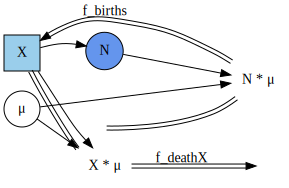

In [3]:
GraphF(apex(openX))

## 1.2 The SIS sub-model structure

In [4]:
openSIS_A = Open(
    (@stock_and_flow begin

        :stocks
        X
        A

        :parameters
        μ_temp1 # going to compose all μ in Rewriting.  Shouldn't be necessary on params.
        ϕ_complement
        σ′
        cβ

        :dynamic_variables
        v_inf₁ = cβ * NI
        v_inf₂ = v_inf₁ / N
        v_inf₃ = v_inf₂ * X
        v_inf₄ = v_inf₃ * ϕ_complement

        v_deathA = A * μ_temp1

        :flows
        X => f_newInfectiousA(v_inf₄) => A
        A => f_deathA(v_deathA) => CLOUD
        A => f_recoveryA(A * σ′) => X

        :sums
        N = [X, A]
        NI = [A]

    end
    ),
     # feet
     foot(:X,:N,:X=>:N),
     foot((),:NI,())

)

StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, Multicospan{StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAl

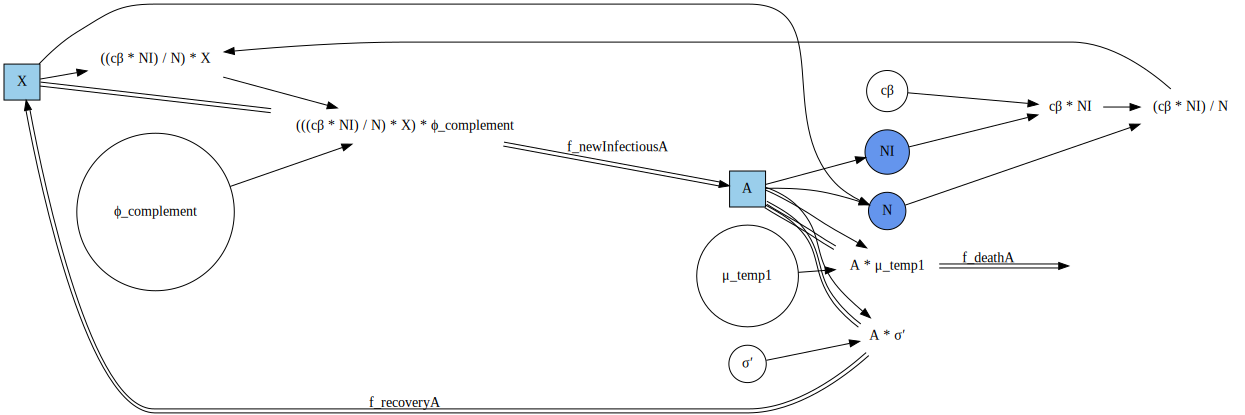

In [5]:
GraphF(apex(openSIS_A))

In [6]:
openSIS_Y = Open(
    (@stock_and_flow begin
    
    :stocks
    X
    Y

    :parameters
    μ_temp2
    ϕ
    σ
    λ

    :dynamic_variables
    v_inf₄ = ϕ * λ # at present, lambda needs to come second
    # in algebraic rewriting, position of variables matters for homomorphisms.
    # When we later have *(ϕ), phi comes first, because it's the only variable
    
    v_deathY = Y * μ_temp2

    :flows
    X => f_newInfectiousY(v_inf₄) => Y
    Y => f_deathY(v_deathY) => CLOUD
    Y => f_recoveryY(Y * σ) => X

    :sums
    N = [X, Y]
    NI = [Y]

end
        ),

     # feet
     foot(:X,:N,:X=>:N),
     foot((),:NI,())
    
)

StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, Multicospan{StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAl

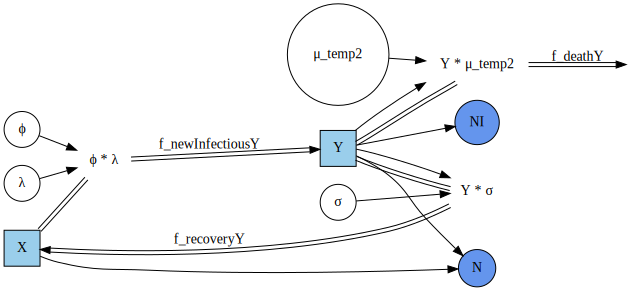

In [7]:
GraphF(apex(openSIS_Y))

# 2 Compose
## 2.1 Define composition rule

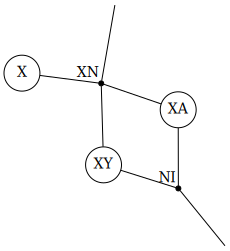

In [8]:
# define the UWD-algebra
uwd = @relation (XN,NI) begin
    X(XN)
    XA(XN,NI)
    XY(XN,NI)
end;
display_uwd(uwd)

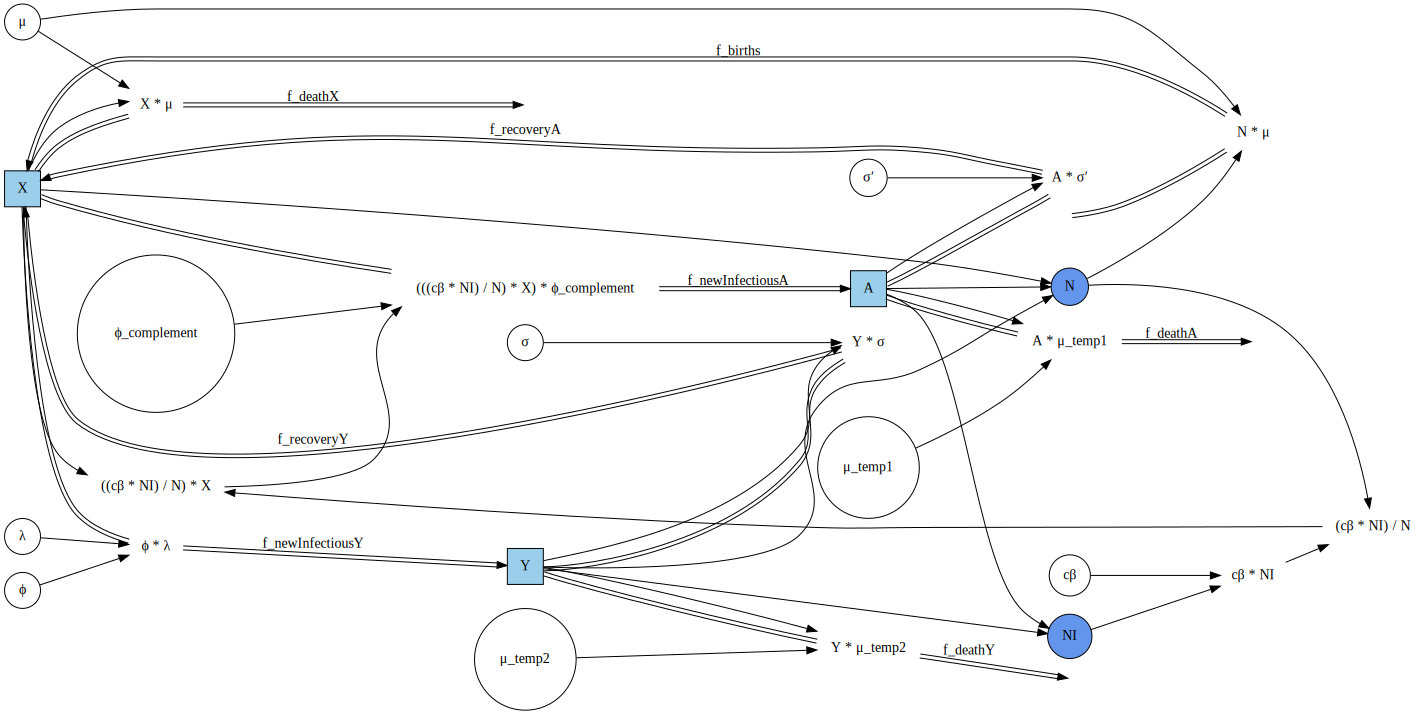

In [9]:
XAY_model = oapply(uwd,Dict(
    :X=>openX,
    :XA=>openSIS_A,
    :XY=>openSIS_Y
    )) |> apex
GraphF(XAY_model)

In [10]:
XAY_model

StockAndFlowF with elements S = 1:3, SV = 1:2, LS = 1:5, F = 1:8, I = 1:5, O = 1:7, V = 1:11, LV = 1:6, LSV = 1:3, P = 1:9, LVV = 1:3, LPV = 1:10
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
│ 2 │     A │
│ 3 │     Y │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   2 │    2 │
│  4 │   3 │    1 │
│  5 │   3 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────────────┐
│ F │ fv │            fname │
├───┼────┼──────────────────┤
│ 1 │  1 │         f_births │
│ 2 │  2 │         f_deathX │
│ 3 │  6 │ f_newInfectiousA │
│ 4 │  7 │         f_deathA │
│ 5 │  8 │      f_recoveryA │
│ 6 │  9 │ f_newInfectiousY │
│ 7 │ 10 │         f_deathY │
│ 8 │ 11 │      f_recoveryY │
└───┴────┴──────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   5 │  1 │
│ 3 │   3 │  2 │
│ 4 │   8 │  1 │
│ 5 │   6 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   3 │  1 │
│ 3 │   4 │  2 │
│ 4 │   5 │  2 │
│ 5 │   6 │  1 │
│ 6 │   7 │  3 │
│ 7 │   8 │  3 │
└───┴─────┴────┘
┌────┬─────────────────────┬─────┐
│  V │               vname │ vop │
├────┼─────────────────────┼─────┤
│  1 │            v_births │   * │
│  2 │            v_deathX │   * │
│  3 │              v_inf₁ │   * │
│  4 │              v_inf₂ │   / │
│  5 │              v_inf₃ │   * │
│  6 │              v_inf₄ │   * │
│  7 │            v_deathA │   * │
│  8 │ ##v_f_recoveryA#292 │   * │
│  9 │              v_inf₄ │   * │
│ 10 │            v_deathY │   * │
│ 11 │ ##v_f_recoveryY#293 │   * │
└────┴─────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   2 │           1 │
│  2 │   1 │   5 │           2 │
│  3 │   2 │   7 │           1 │
│  4 │   2 │   8 │           1 │
│  5 │   3 │  10 │           1 │
│  6 │   3 │  11 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             1 │
│   2 │     2 │    3 │             2 │
│   3 │     1 │    4 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬──────────────┐
│ P │        pname │
├───┼──────────────┤
│ 1 │            μ │
│ 2 │      μ_temp1 │
│ 3 │ ϕ_complement │
│ 4 │           σ′ │
│ 5 │           cβ │
│ 6 │      μ_temp2 │
│ 7 │            ϕ │
│ 8 │            σ │
│ 9 │            λ │
└───┴──────────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     3 │     4 │             1 │
│   2 │     4 │     5 │             1 │
│   3 │     5 │     6 │             1 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            2 │
│   2 │    1 │    2 │            2 │
│   3 │    5 │    3 │            1 │
│   4 │    3 │    6 │            2 │
│   5 │    2 │    7 │            2 │
│   6 │    4 │    8 │            2 │
│   7 │    7 │    9 │            1 │
│   8 │    9 │    9 │            2 │
│   9 │    6 │   10 │            2 │
│  10 │    8 │   11 │            2 │
└─────┴──────┴──────┴──────────────┘

# 3 Rewrite

In [11]:
L = @stock_and_flow begin
    :stocks
    X
    Y
    A

    :parameters
    μ
    μ_temp1
    μ_temp2
    λ
    cβ
    ϕ

    :dynamic_variables
    v_inf₁ = cβ * NI
    v_inf₂ = v_inf₁ / N
    v_inf₃ = v_inf₂ * X
    v_inf₄ = ϕ * λ

    v_deathA = A * μ_temp1
    v_deathY = Y * μ_temp2

    v_births = N * μ
    v_deathX = X * μ

    :flows
    X => f_newInfectiousY(v_inf₄) => Y
    Y => f_deathY(v_deathY) => CLOUD
    A => f_deathA(v_deathA) => CLOUD

    CLOUD => f_births(v_births) => X
    X => f_deathX(v_deathX) => CLOUD


    
    :sums
    N = [X,Y,A]
    NI = [Y,A]
    end;
     


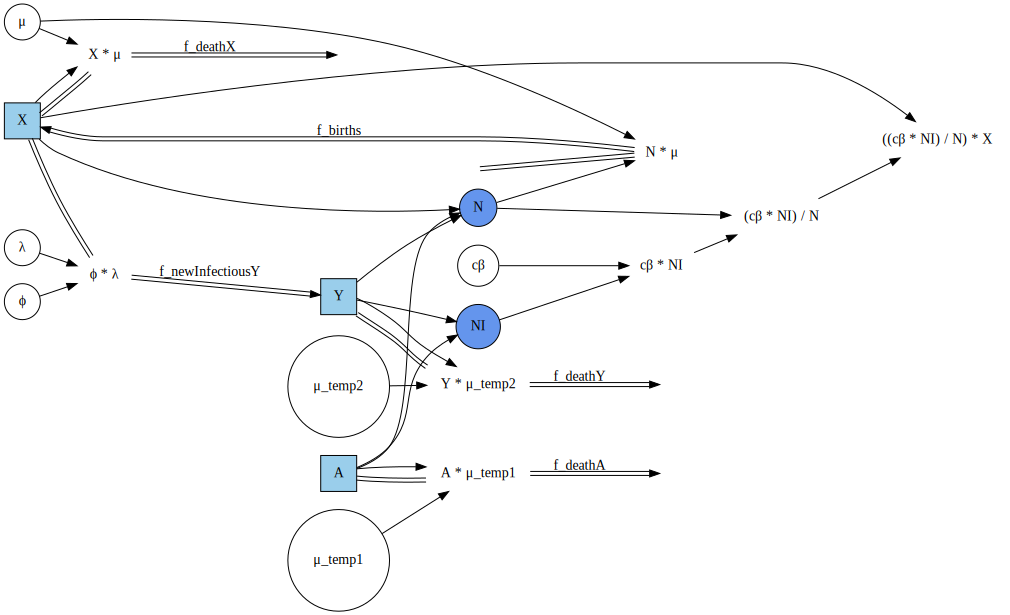

In [12]:
GraphF(L)

In [13]:
I = @stock_and_flow begin
    :stocks
    A
    X
    Y

    :parameters
    μ
    cβ
    ϕ

    :dynamic_variables
    v_inf₁ = cβ * NI
    v_inf₂ = v_inf₁ / N
    v_inf₃ = v_inf₂ * X
    v_inf₄ = *(ϕ)


    v_deathA = *(A)
    v_deathY = *(Y)

    v_births = N * μ
    v_deathX = X * μ


    



    :flows
    X => f_newInfectiousY(v_inf₄) => Y
    Y => f_deathY(v_deathY) => CLOUD
    A => f_deathA(v_deathA) => CLOUD

    CLOUD => f_births(v_births) => X
    X => f_deathX(v_deathX) => CLOUD


    
    :sums
    N = [X,Y,A]
    NI = [Y,A]
    end;
     

   

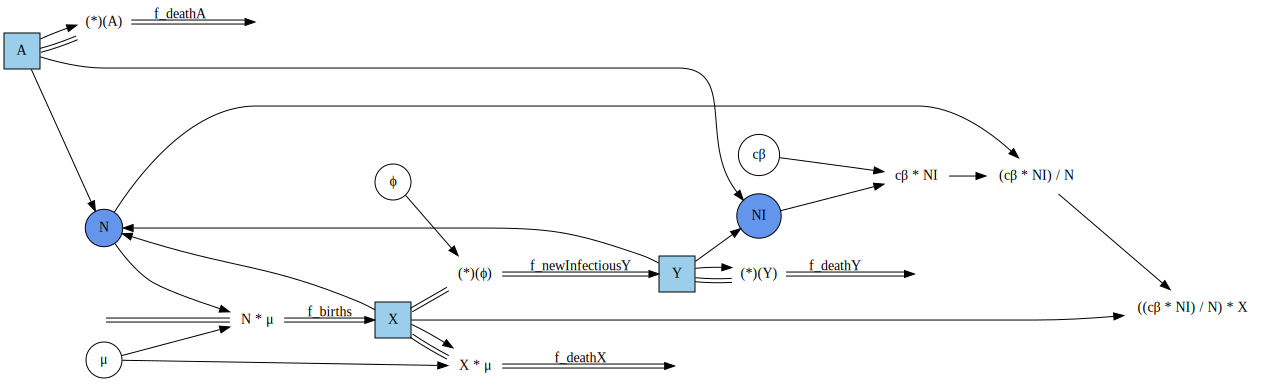

In [14]:
GraphF(I)

In [15]:
R = @stock_and_flow begin
    :stocks
    A
    X
    Y

    :parameters
    μ
    cβ
    ϕ

    :dynamic_variables
    v_inf₁ = cβ * NI
    v_inf₂ = v_inf₁ / N
    v_inf₃ = v_inf₂ * X
    v_inf₄ = ϕ * v_inf₃

    v_deathA = A * μ
    v_deathY = Y * μ

    v_births = N * μ
    v_deathX = X * μ

    :flows
    X => f_newInfectiousY(v_inf₄) => Y

    Y => f_deathY(v_deathY) => CLOUD
    A => f_deathA(v_deathA) => CLOUD

    CLOUD => f_births(v_births) => X
    X => f_deathX(v_deathX) => CLOUD


    :sums
    N = [X,Y,A]
    NI = [Y,A]
    end;
     


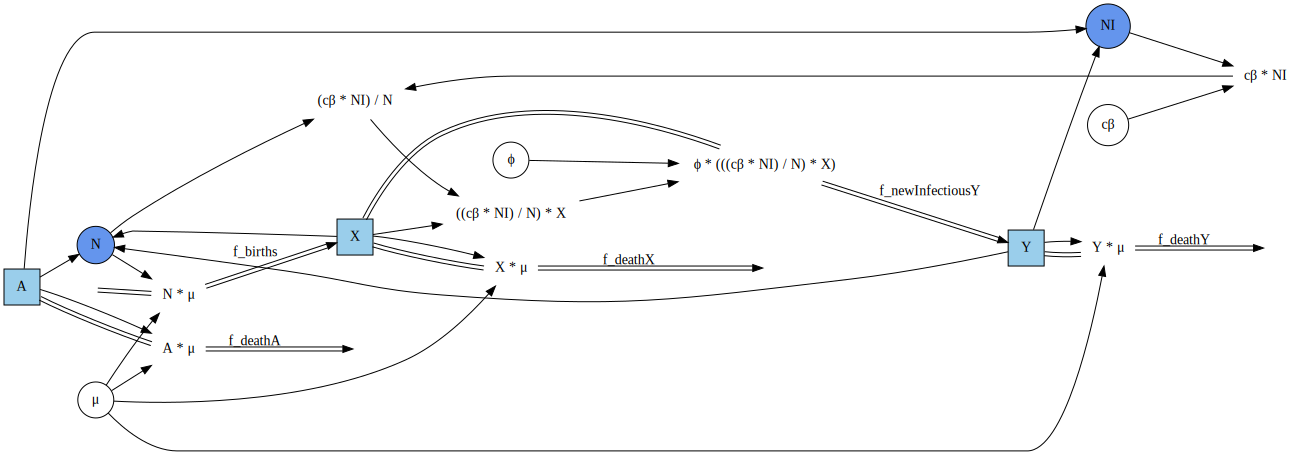

In [16]:
GraphF(R)

In [17]:
using AlgebraicRewriting
using AlgebraicRewriting: rewrite
const hom = AlgebraicRewriting.homomorphism
rule = Rule(hom(I,L), hom(I,R))

Rule{:DPO}(ACSetTransformation((S = FinFunction([3, 1, 2], 3, 3), SV = FinFunction([1, 2], 2, 2), LS = FinFunction([4, 5, 1, 2, 3], 5, 5), F = FinFunction([1, 2, 3, 4, 5], 5, 5), I = FinFunction([1, 2], 2, 2), O = FinFunction([4, 1, 2, 3], 4, 4), V = FinFunction([1, 2, 3, 4, 5, 6, 7, 8], 8, 8), LV = FinFunction([1, 2, 3, 4], 4, 4), LSV = FinFunction([1, 2, 3], 3, 3), P = FinFunction([1, 5, 6], 3, 6), LVV = FinFunction([1, 2], 2, 2), LPV = FinFunction([1, 2, 6, 7], 4, 7)), StockAndFlowF {S = 3, SV = 2, LS = 5, F = 5, I = 2, O = 4, V = 8, LV = 4, LSV = 3, P = 3, LVV = 2, LPV = 4}, StockAndFlowF {S = 3, SV = 2, LS = 5, F = 5, I = 2, O = 4, V = 8, LV = 4, LSV = 3, P = 6, LVV = 2, LPV = 7}), ACSetTransformation((S = FinFunction([1, 2, 3], 3, 3), SV = FinFunction([1, 2], 2, 2), LS = FinFunction([1, 2, 3, 4, 5], 5, 5), F = FinFunction([1, 2, 3, 4, 5], 5, 5), I = FinFunction([1, 2], 2, 2), O = FinFunction([1, 2, 3, 4], 4, 4), V = FinFunction([1, 2, 3, 4, 5, 6, 7, 8], 8, 8), LV = FinFunction([1

In [18]:
XAY_model_rewritten = rewrite(rule, XAY_model)

StockAndFlowF with elements S = 1:3, SV = 1:2, LS = 1:5, F = 1:8, I = 1:5, O = 1:7, V = 1:11, LV = 1:6, LSV = 1:3, P = 1:6, LVV = 1:4, LPV = 1:9
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     A │
│ 2 │     X │
│ 3 │     Y │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   1 │    2 │
│  3 │   2 │    1 │
│  4 │   3 │    1 │
│  5 │   3 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────────────┐
│ F │ fv │            fname │
├───┼────┼──────────────────┤
│ 1 │  4 │ f_newInfectiousY │
│ 2 │  6 │         f_deathY │
│ 3 │  5 │         f_deathA │
│ 4 │  7 │         f_births │
│ 5 │  8 │         f_deathX │
│ 6 │  9 │ f_newInfectiousA │
│ 7 │ 10 │      f_recoveryA │
│ 8 │ 11 │      f_recoveryY │
└───┴────┴──────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   4 │  2 │
│ 2 │   1 │  3 │
│ 3 │   7 │  2 │
│ 4 │   6 │  1 │
│ 5 │   8 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   3 │  1 │
│ 2 │   1 │  2 │
│ 3 │   5 │  2 │
│ 4 │   2 │  3 │
│ 5 │   6 │  2 │
│ 6 │   7 │  1 │
│ 7 │   8 │  3 │
└───┴─────┴────┘
┌────┬─────────────────────┬─────┐
│  V │               vname │ vop │
├────┼─────────────────────┼─────┤
│  1 │              v_inf₁ │   * │
│  2 │              v_inf₂ │   / │
│  3 │              v_inf₃ │   * │
│  4 │              v_inf₄ │   * │
│  5 │            v_deathA │   * │
│  6 │            v_deathY │   * │
│  7 │            v_births │   * │
│  8 │            v_deathX │   * │
│  9 │              v_inf₄ │   * │
│ 10 │ ##v_f_recoveryA#292 │   * │
│ 11 │ ##v_f_recoveryY#293 │   * │
└────┴─────────────────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   2 │   3 │           2 │
│  2 │   1 │   5 │           1 │
│  3 │   3 │   6 │           1 │
│  4 │   2 │   8 │           1 │
│  5 │   1 │  10 │           1 │
│  6 │   3 │  11 │           1 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     2 │    1 │             2 │
│   2 │     1 │    2 │             2 │
│   3 │     1 │    7 │             1 │
└─────┴───────┴──────┴───────────────┘
┌───┬──────────────┐
│ P │        pname │
├───┼──────────────┤
│ 1 │            μ │
│ 2 │           cβ │
│ 3 │            ϕ │
│ 4 │ ϕ_complement │
│ 5 │           σ′ │
│ 6 │            σ │
└───┴──────────────┘
┌─────┬───────┬───────┬───────────────┐
│ LVV │ lvsrc │ lvtgt │ lvsrcposition │
├─────┼───────┼───────┼───────────────┤
│   1 │     1 │     2 │             1 │
│   2 │     2 │     3 │             1 │
│   3 │     3 │     4 │             2 │
│   4 │     3 │     9 │             1 │
└─────┴───────┴───────┴───────────────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    2 │    1 │            1 │
│   2 │    3 │    4 │            1 │
│   3 │    1 │    5 │            2 │
│   4 │    1 │    6 │            2 │
│   5 │    1 │    7 │            2 │
│   6 │    1 │    8 │            2 │
│   7 │    4 │    9 │            2 │
│   8 │    5 │   10 │            2 │
│   9 │    6 │   11 │            2 │
└─────┴──────┴──────┴──────────────┘

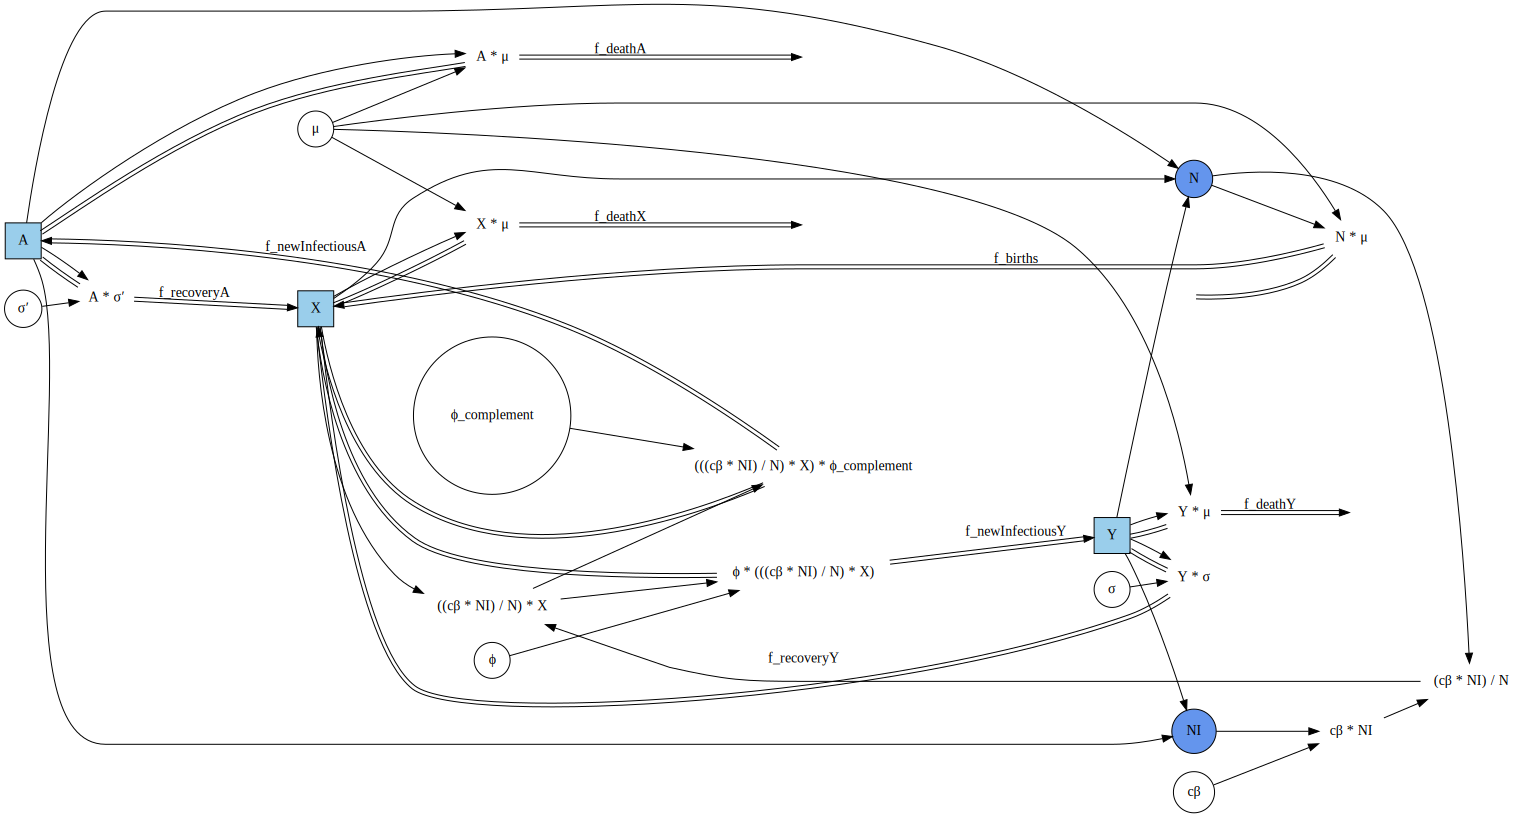

In [19]:
GraphF(XAY_model_rewritten)

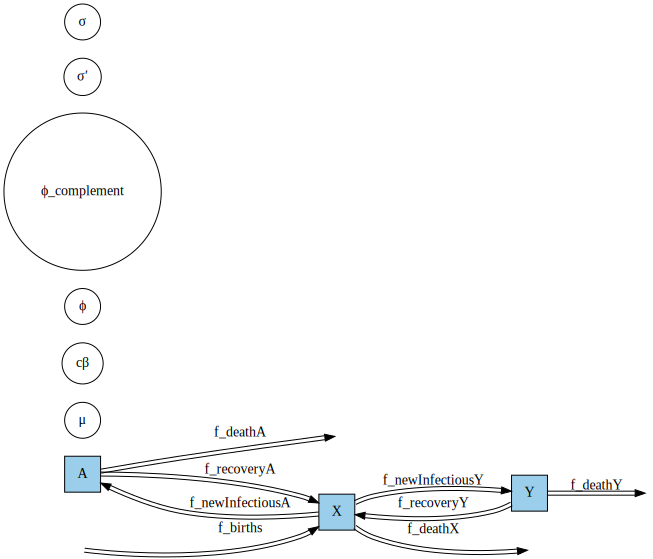

In [20]:
GraphF(XAY_model_rewritten,type="SF")

# 3. Solve ODEs

In [21]:
# define values of constant parameters
# unit: year
p = LVector(
    cβ=15*0.7, μ=1/15,ϕ=(0.95+0.4)/2,σ=12/4,σ′=12/4,ϕ_complement=(1.0 - ((0.95+0.4)/2))
)
# define initial values for stocks
u0 = LVector(
    X=990, A=5, Y=5
)

3-element LArray{Int64, 1, Vector{Int64}, (:X, :A, :Y)}:
 :X => 990
 :A => 5
 :Y => 5

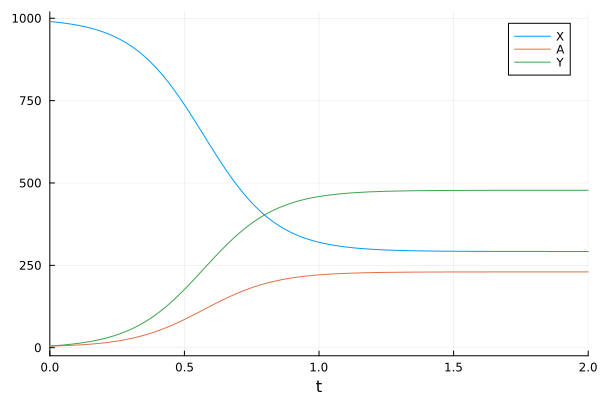

In [22]:
# results are tested the same as the Anylogic model
prob_XAY = ODEProblem(vectorfield(XAY_model_rewritten),u0,(0.0,2.0),p);
sol = solve(prob_XAY,Tsit5(),abstol=1e-8);
plot(sol)

In [23]:
# to have the figures plotted fix to the wider of the cells
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")


HTML{String}("<style>\n.output_svg div{\n  width: 100% !important;\n  height: 100% !important;\n}\n</style>\n")